# Today's topics
We will try to find out which phenotypic traits are associated with genetic markers in the BXD mouse population. This will allow us to make statements about the level of heritability of several traits as well as help us identify candidate genes responsible for specific traits.

There are several types of studies relevant in this context:

* Single gene association studies
* Genome wide association studies
* Phenome wide association studies

# GWAS background

http://www.ncbi.nlm.nih.gov/pmc/articles/PMC2736153/ contains information about how to use genenetwork.org to find coat color phenotype and correlate that to expression levels

# Useful Resources

## Packages

### R
* [Matrix eQTL](http://www.bios.unc.edu/research/genomic_software/Matrix_eQTL/)
* [GWAS Tools](http://bioconductor.org/packages/release/bioc/html/GWASTools.html)
* [GenABEL](http://www.genabel.org/)


### Python
* [llmlite](http://kbroman.org/lmmlite/assets/compare2pylmm.html)
* [pylmm](http://genetics.cs.ucla.edu/pylmm/)
* [fstlmm](http://lomereiter.github.io/2015/02/16/lmm_cov.html)
* [pyGWAS](https://github.com/timeu/PyGWAS)
* [krux](https://github.com/tmichoel/krux/blob/master/python/kruX.py)

## Books
* [James, Witten, Hastie, Tibshirani, An Introduction to Statistical Learning, Springer Texts, 2013](http://www-bcf.usc.edu/~gareth/ISL/)      
* [MacKay, Information Theory, Inference, and Learning Algorithms, Cambridge University Press, 2005](http://www.inference.phy.cam.ac.uk/itila/book.html)


## Tutorials
* [Logistic regression](http://blog.yhat.com/posts/logistic-regression-and-python.html)   
* [Linear regression](http://www.dataschool.io/linear-regression-in-python/)

# Load data
Before you can work with the data you have to load it and tidy it up a bit. This includes filtering rows with missing values, making sure that numeric columns are indeed of a numeric data type in the data frame, ...

## Load genotype data as pandas dataframe
Follow the same procedure as done yesterday. You do not have to download the file again, but can load it from your originally stored location.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import scipy.sparse as sparse
import random
from statsmodels.sandbox.stats.multicomp import multipletests


genotype = pd.read_csv('files/dataS4.txt', sep='\t', comment='@')
genotype.head()

,Chr,Locus,cM,Mb,BXD1,BXD2,BXD5,BXD6,BXD8,BXD9,...,BXD90,BXD91,BXD93,BXD94,BXD95,BXD98,BXD99,BXD100,BXD101,BXD102
0,1,rs6269442,0.000,3.482275,B,B,D,D,D,B,...,B,D,B,D,D,B,B,B,B,B
1,1,rs6365999,0.000,4.811062,B,B,D,D,D,B,...,B,D,B,D,D,B,B,B,B,U
2,1,rs6376963,0.895,5.008089,B,B,D,D,D,B,...,B,D,B,D,D,B,B,B,B,U
3,1,rs3677817,1.185,5.176058,B,B,D,D,D,B,...,B,D,B,D,D,B,B,B,B,U
4,1,rs8236463,2.081,5.579193,B,B,D,D,D,B,...,B,D,B,D,D,B,B,B,B,U


## Subtask: Set SNP-ID column as index

In [2]:
genotype.set_index('Locus', inplace=True)
genotype.head()

,Chr,cM,Mb,BXD1,BXD2,BXD5,BXD6,BXD8,BXD9,BXD11,...,BXD90,BXD91,BXD93,BXD94,BXD95,BXD98,BXD99,BXD100,BXD101,BXD102
Locus,,,,,,,,,,,,,,,,,,,,,
rs6269442,1,0.000,3.482275,B,B,D,D,D,B,B,...,B,D,B,D,D,B,B,B,B,B
rs6365999,1,0.000,4.811062,B,B,D,D,D,B,B,...,B,D,B,D,D,B,B,B,B,U
rs6376963,1,0.895,5.008089,B,B,D,D,D,B,B,...,B,D,B,D,D,B,B,B,B,U
rs3677817,1,1.185,5.176058,B,B,D,D,D,B,B,...,B,D,B,D,D,B,B,B,B,U
rs8236463,1,2.081,5.579193,B,B,D,D,D,B,D,...,B,D,B,D,D,B,B,B,B,U


## Subtask: Replace categorical data strings with numerical encoding

Let's assume the following mapping from the categorical variable to integers.

|strain| value  |
|------|--------|
|  B   |  0     |
|  H   |  1     |
|  D   |  2     |
|  U   | missing (NAN)|

In [3]:
#Make dictionary for encoding
encode = {'B' : 0, 'D' : 2, 'U' : None, 'H': 1}
df_geno = genotype.iloc[:,3:]

#Apply to the dataframe
df_geno = df_geno.applymap(encode.get)
df_geno.head()

,BXD1,BXD2,BXD5,BXD6,BXD8,BXD9,BXD11,BXD12,BXD13,BXD14,...,BXD90,BXD91,BXD93,BXD94,BXD95,BXD98,BXD99,BXD100,BXD101,BXD102
Locus,,,,,,,,,,,,,,,,,,,,,
rs6269442,0,0,2,2.0,2,0,0,2,0,0,...,0.0,2,0,2.0,2,0,0,0,0.0,0.0
rs6365999,0,0,2,2.0,2,0,0,2,0,0,...,0.0,2,0,2.0,2,0,0,0,0.0,NaN
rs6376963,0,0,2,2.0,2,0,0,2,0,0,...,0.0,2,0,2.0,2,0,0,0,0.0,NaN
rs3677817,0,0,2,2.0,2,0,0,2,0,0,...,0.0,2,0,2.0,2,0,0,0,0.0,NaN
rs8236463,0,0,2,2.0,2,0,2,2,0,0,...,0.0,2,0,2.0,2,0,0,0,0.0,NaN


## Subtask: Drop rows with unknown genotypes

In [4]:
df_geno = df_geno.dropna()
df_geno.head()

,BXD1,BXD2,BXD5,BXD6,BXD8,BXD9,BXD11,BXD12,BXD13,BXD14,...,BXD90,BXD91,BXD93,BXD94,BXD95,BXD98,BXD99,BXD100,BXD101,BXD102
Locus,,,,,,,,,,,,,,,,,,,,,
rs6269442,0,0,2,2.0,2,0,0,2,0,0,...,0.0,2,0,2.0,2,0,0,0,0.0,0.0
rs6241531,0,0,2,2.0,2,0,2,2,0,0,...,0.0,2,0,2.0,2,0,0,0,0.0,2.0
rs6360236,0,0,2,2.0,2,0,2,2,0,0,...,0.0,2,0,2.0,2,0,0,0,0.0,2.0
rs3722996,0,0,2,2.0,2,0,2,2,0,0,...,0.0,2,0,2.0,2,0,0,0,0.0,2.0
D1Mit1,0,0,2,2.0,2,0,2,2,0,0,...,0.0,2,0,2.0,2,0,0,0,0.0,2.0


## Dowload categorical data from genenetworks.org

Most mouse phenotype data is available at genenetwork.org. This includes nearly all published phenotype measurements. You can access individual measurements from that repository using the search mask:
1. Go to http://gn2.genenetwork.org/
2. In "Select and Search" fill in:
    1. Species: Mouse
    2. Group: BXD
    3. Type: Phenotypes
    4. Dataset: BXD Published Phenotypes
3. Enter the trait of interest in the "Get any" field
4. Search

For getting data on the coat color of BXD mice use "coat color" as search term and select the Record 11280 to get to the corresponding __Trait Data and Analysis__ page. There you can download the data as text file.

## Load phenotype data (coat color)

From the source of the genotype data we know the mapping between the categorical color value
and the actual color.

|color  | value  |
|-------|--------|
| black |  4     |
| grey  |  3     |
| brown |  2     |
| dilute|  1     |

In [5]:
phenotype = pd.read_csv('files/phenotype.csv', sep=',', comment='@', header=None, index_col=0, na_values = 'x')
phenotype.head()

,1
0,
C57BL/6J,4.0
DBA/2J,1.0
B6D2F1,4.0
D2B6F1,4.0
BXD1,1.0


## Subtask: remove rows with missing data

In [6]:
df_pheno = phenotype.dropna()
df_pheno.shape

(199, 1)

## Convert data to numeric

In [7]:
df_pheno.iloc[:,0] = pd.to_numeric(df_pheno.iloc[:,0])


/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


# Association tests between variant(s) and categorical phenotype
We will first start testing SNPs for their association with an easily characterizable phenotype: coat color. As you could see in the slides, BXD mice come in different colors (black, brown, dilute) and as you know, hair color is heritable. In this task you will thus try to find candidate genes that are involved in coat color determination in the mouse population.

Note: Nearly all variability in BXD mice has been associated with three genes: _Tyrp1_(brown, chr 4), _Myo5a_ (dilute, chr 9) and _Asip_ (non-agouti, i.e. one color) ([PMC2736153](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC2736153)). We will now check if we see this association using the 3700 SNPs in our genotype.

## Task: Perfom association test for a single SNP using $\chi^2$ test and odds ratio

### Subtask: Extract row of a single SNP (e.g. rs6232550)

In [8]:
#Extract single SNP
single_snp = df_geno.loc['rs6232550']
single_snp.head()

BXD1    2.0
BXD2    0.0
BXD5    0.0
BXD6    0.0
BXD8    0.0
Name: rs6232550, dtype: float64

### Subtask: Remove all non-strain genotye columns

In [9]:
#Already done before for the whole dataset

### Subtask: Combine SNP data with phenotype data
hint: it might be necessary to transpose the row, depending on what format is has (not necessary for a pandas Series)

In [10]:
#Do it by an inner join to prevent NAN values
df_combined = df_pheno.join(single_snp, how="inner")
df_combined.shape

(90, 2)

### Subtask: Check that the merging worked

In [11]:
df_combined = df_combined.dropna()
df_combined.head()

,1,rs6232550
BXD1,1.0,2.0
BXD2,4.0,0.0
BXD5,3.0,0.0
BXD6,3.0,0.0
BXD8,3.0,0.0


### Subtask: Plot relationship between genotye and phenotype

you can use a scatter plot, but equal values will occlude each other <br>
hint: add a jitter by adding a random sample from [-x,x] for some x < 0.5 to each value

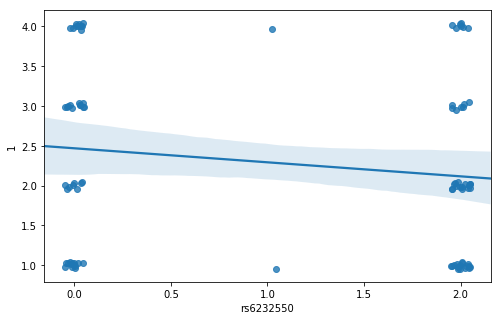

In [12]:
df_combined_withnoise = df_combined.applymap(lambda x: x+random.uniform(-0.05,0.05))

plt.figure(figsize=(8,5))

plt.xlabel('Genotype', fontsize=10)
plt.ylabel('Coat color', fontsize=10)

rplot = sns.regplot(x=df_combined_withnoise['rs6232550'], y=df_combined_withnoise[1])


In my humble opinion I would say that there is no correlation between the rs6232550 SNP and the coat color observable.

### Subtask: Create contingency table for a D-dominant inheritance model of black coat color and SNP rs6232550
Tip: pandas' crosstab functionality may be helpful here and the [reshaping/crosstab documentation](http://pandas-docs.github.io/pandas-docs-travis/reshaping.html) as illustrated in [this tutorial](http://wesmckinney.com/blog/contingency-tables-and-cross-tabulations-in-pandas/) may be helpful.

In [13]:
#use cross-tab
con_table = pd.crosstab(df_combined.iloc[:,0]==4, df_combined.iloc[:,1]==2)
con_table

rs6232550,False,True
1,,
False,33,38
True,12,7


### Subtask: Perform $\chi^2$ square test for independence on the contingency table

In [14]:
chi2, p, dof, ex = stats.chi2_contingency(con_table, correction=True)
chi2, dof, p, ex

(1.0674573758339512, 1, 0.3015204713993809, array([[35.5, 35.5],
        [ 9.5,  9.5]]))

### Subtask: Write function to calculate odds ratio from a contingency table

In [15]:
#Use fishers exact test

def calculate_odds(con_table):
    oddsratio, pvalue = stats.fisher_exact(con_table)
    return oddsratio


In [16]:
print('Odds ratio: '+ str(calculate_odds(con_table)))

Odds ratio: 0.506578947368421


## Task: extend statistical method for a penetrance model in which increasing numbers of A alleles confer a trend in risk (e.g. additive or dominant)

While you can model most of the penetrance models described in the lecture in a 2x2 contingency table and thus perform a $\chi^2$ test with one degree of freedom, it may sometimes be useful to consider the full complexity of a genotype contigency table considering all three possible genotypes instead of just two (even though the latter has larger statistical power). Apart from a $\chi^2$ test with two degrees of freedom, the Cochran–Armitage trend test is commonly used in genetic association tests as this has often larger statistical power. In this case, if the exact model of penetrance is not known, an additive approach is often used. 

You can read more about basic statistical approaches in genetic association tests in the following paper:

__G. Clarke et al.       
[Basic statistical analysis in genetic case-control studies](http://www.nature.com/nprot/journal/v6/n2/full/nprot.2010.182.html)__,      
Nat. Protocols, 2011/02,     
http://dx.doi.org/10.1038/nprot.2010.182


### Subtask: Given the data you have, could you calculate this type of statistic for your data?

* If yes, please implement the creation of a contingency table and the test.
* If no, please explain why.

Since there are almost no heterozygote alleles existent in the dataset, performing such a test would not be very interesting. However it would be possible but better use Cochran-Armitage.

## Task: Refactor previous analysis steps into a function and apply to all SNPs

Things to consider:
* What information is needed as input in each round?
* Do you want to support $\chi^2$ and Cochran–Armitage test?
* What information as output is needed?
* Should multiple inheritance models be included?
* Should the user get to chose which hair color to test?

In [17]:
chi_square_p_value = []
odds_ratio = []
names = []

for i in range(0, len(df_geno)):
    
    #take every SNP
    snp = df_geno.iloc[i]
    snp = pd.to_numeric(snp)
    
    #Combine the current SNP with the coat color dataset
    df_combined = df_pheno.join(snp, how="inner")
    
    #Do the test
    con_table = pd.crosstab(df_combined.iloc[:,0]==4, df_combined.iloc[:,1]==2)
    chi2, p, dof, ex = stats.chi2_contingency(con_table, correction=True)

    #Save the results in lists
    chi_square_p_value.append(p)
    odds_ratio.append(calculate_odds(con_table))
    names.append(df_geno.index[i])

#Combine the results into a dataframe
df_allSNPs = pd.DataFrame()
df_allSNPs['SNP']  = names
df_allSNPs['p value'] = chi_square_p_value
df_allSNPs['odds ratio'] = odds_ratio

df_allSNPs.set_index('SNP', inplace=True)

df_allSNPs.head()

,p value,odds ratio
SNP,,
rs6269442,0.007168,0.128028
rs6241531,0.125858,0.344086
rs6360236,0.065480,0.290196
rs3722996,0.065480,0.290196
D1Mit1,0.040330,0.259259


### Subtask: Create Manhattan Plot of  $-\log_{10}(\text{P-value})$ vs chromosome position 
A Manhattan plot, named after its resemblance to the skyline of Manhattan, is commonly used to plot the p-value obtained for individual association tests for each SNP compared to the SNP's position on the genome as shown in the example below.

Technically, a Manhattan plot is a scatter plot of genome position (for each chromosome) vs the negative logarithm of the p-value.

Try to approximate the following plot as closely as possible:

<img src='Manhattan.png'>

In [18]:
#Add chosomal and position information

df_manhatten = df_allSNPs.join(genotype['Chr'], how="inner")
df_manhatten = df_manhatten.join(genotype['Mb'], how="inner")
df_manhatten.head()


,p value,odds ratio,Chr,Mb
rs6269442,0.007168,0.128028,1,3.482275
rs6241531,0.125858,0.344086,1,9.995925
rs6360236,0.065480,0.290196,1,11.073904
rs3722996,0.065480,0.290196,1,11.259432
D1Mit1,0.040330,0.259259,1,11.505582


In [19]:
def manhattenplot(df_manhatten, colToPrint):
    
    df_manhattenplot = df_manhatten.copy()
    
    #Compute  max pos per chromosome
    offsets = df_manhattenplot.groupby('Chr', sort=False).Mb.max().cumsum()

    offsets -= offsets.loc['1']
    #Compute total base positon over the whole genome not just the chromosome
    df_manhatten_totalmb = df_manhattenplot.apply(lambda x: x.Mb + offsets.loc[x.Chr], axis=1)

    df_manhattenplot.insert(3, 'totalMb', df_manhatten_totalmb)

    #Color code for the different chromosoms
    colors = {'1':'darkred', '2':'darkorange', '3':'lightgreen', '4':'green', '5':'cyan', '6':'blue', '7':'purple', '8':'violet', '9':'darkred', '10':'darkorange', '11':'lightgreen', '12':'green' , '13':'cyan', '14':'blue', '15':'purple', '16':'violet', '17':'darkred', '18':'darkorange', '19':'lightgreen', 'X':'green'}

    fig, ax = plt.subplots(figsize=(20,5))

    plt.scatter(x=df_manhattenplot['totalMb'], y=-np.log10(df_manhattenplot[colToPrint]), c=df_manhattenplot['Chr'].apply(lambda x: colors[x]))
    plt.title('Manhattan Plot')
    plt.xlabel('Position on Genome in Mb')
    plt.ylabel('-log p')


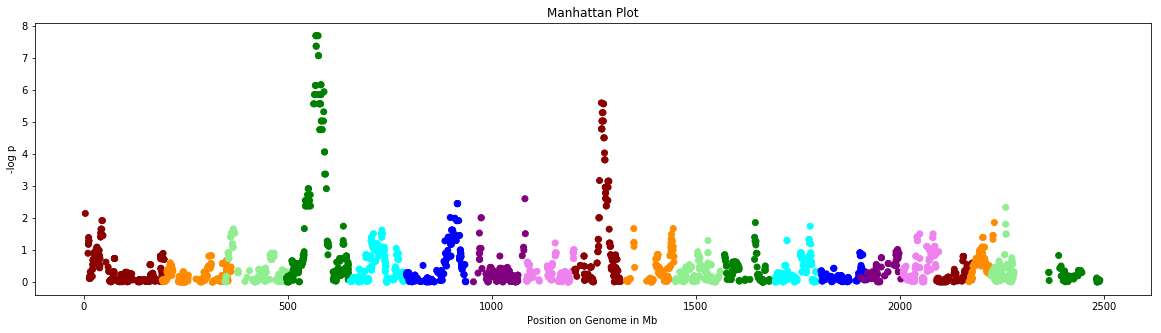

In [20]:
manhattenplot(df_manhatten, 'p value')

The so-called Manhatten plot, for its resemblance to its skyline, shows us the genomic coordinates along the X-axis, with the negative logarithm of the association P-value for each SNP on the Y-axis. Each dot encodes one SNP. Because the strongest associations have the smallest P-values, their negative logarithms will be the greatest and visible as peaks. In the plot above each chromosom is colored in a different hue and peks, aka strong associations can be seen with SNPS on chromosome 4 and 9. 

### Subtask: If you have time, try to implement alternative inheritance models

In [21]:
#Ain't Nobody Got Time For That

## Task: Correct for Multiple Hypothesis Testing

Employ one of the correction methods described in the lecture to take care of the multiple hypothesis testing.

In [22]:
df_manhatten.head()

,p value,odds ratio,Chr,Mb
rs6269442,0.007168,0.128028,1,3.482275
rs6241531,0.125858,0.344086,1,9.995925
rs6360236,0.065480,0.290196,1,11.073904
rs3722996,0.065480,0.290196,1,11.259432
D1Mit1,0.040330,0.259259,1,11.505582


In [23]:
rej, corrected_p, _, _ = multipletests(df_manhatten['p value'], alpha = 0.1, method='fdr_bh')

print(corrected_p)

[0.186729   0.86881    0.71073579 ... 0.99292339 0.99292339 0.99292339]


### Subtask: Wrap your MHT correction in a function
Ideally, the function should allow easy access to several parameters including the target $\alpha$ and the correction method

In [24]:
def mht_correction(pvals, alpha, method):
    rej, corrected_p, _, _ = multipletests(pvals, alpha = alpha, method=method)
    
    df_manhatten['p_corr'] = corrected_p
    
    return df_manhatten


In [25]:
mht_correction(df_manhatten['p value'], 0.1, 'fdr_bh').head()


,p value,odds ratio,Chr,Mb,p_corr
rs6269442,0.007168,0.128028,1,3.482275,0.186729
rs6241531,0.125858,0.344086,1,9.995925,0.868810
rs6360236,0.065480,0.290196,1,11.073904,0.710736
rs3722996,0.065480,0.290196,1,11.259432,0.710736
D1Mit1,0.040330,0.259259,1,11.505582,0.580440


### Subtask: Test if the function works as intended

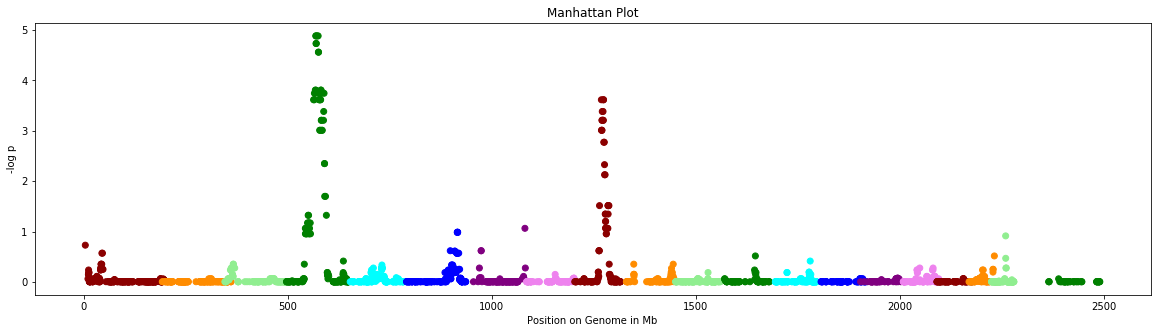

In [26]:
manhattenplot(df_manhatten, 'p_corr')


With the plot above we see that the correction was succesfull. The peaks are now clearly visible and the data with no, or low association is further pushed down to the x axis. 

## Task: Identify candidate genes from identified loci

### Subtask: Identify genes in region identified by significant loci (consider each chromosome separately)

What we identified so far are so called __quantitative trait loci__, meaning that this locus on the genome is associated with a quantitative trait. This does not mean there is directly a causal relationship between the markers identified in the association study and the phenotype. It is, however, a pointer towards the region of the genome that may be relevant for the variability in the measured trait. The genes encompassed in this region then need to be analysed further to identify viable mechanistic candidates.



A good starting point for this fine grained analysis would be to look up the genes directly linked to the SNP in dbSNP  (e.g, http://www.ncbi.nlm.nih.gov/projects/SNP/snp_ref.cgi?rs=rs3674482).

Most likely the high ranking SNPs will not map directly to the causal gene, but will rather be a marker for another variant in a gene in __linkage disequilibrium__ with this this SNP. We thus need to extend the search and look at other genes in the vicinity of the high ranking SNPs.

You may thus want to move on the [Biomart](http://www.ensembl.org/biomart/martview/fb0e89930dcbbdb8075ca52f8b196719) to query for genes in a genomic region.

A third resource you may want to check out is the [UCSC Genome Browser](http://genome.ucsc.edu/) for visual explorations as well as the [UCSC Table Browser](http://genome.ucsc.edu/cgi-bin/hgTables?hgsid=511555905_oFRLEcH1IWO1FdKyzynrsBCRMk7w) to obtain genes in a genomic region. The identifiers of proteins in the [uniprot](http://www.uniprot.org/) database are listed in the resulting table. Uniprot then can provide useful annotations of the proteins found in the search frame.

Programmatic access is possible for all the services above using their REST interfaces:  

[UCSC](http://genomewiki.ucsc.edu/index.php/Programmatic_access_to_the_Genome_Browser)     
[Biomart](http://www.ensembl.org/info/data/biomart/biomart_restful.html)     
[Uniprot](http://www.uniprot.org/help/programmatic_access)     

There have been multiple attempts to make it possible to query these services using python directly. The most important packages are: <br>
[biomart-python](https://github.com/sebriois/biomart)      

If you decide to search for the genes of interest based on the genome location, make sure to select the correct reference genome. The reference used for the BXD genotyping is described in the genotype description on [genenetwork.org](http://www.genenetwork.org/dbdoc/BXDGeno.html)

In [27]:
df_manhatten.head()

,p value,odds ratio,Chr,Mb,p_corr
rs6269442,0.007168,0.128028,1,3.482275,0.186729
rs6241531,0.125858,0.344086,1,9.995925,0.868810
rs6360236,0.065480,0.290196,1,11.073904,0.710736
rs3722996,0.065480,0.290196,1,11.259432,0.710736
D1Mit1,0.040330,0.259259,1,11.505582,0.580440


In [28]:
candidate_genes = df_manhatten[['p_corr']].copy()
candidate_genes.head()


,p_corr
rs6269442,0.186729
rs6241531,0.868810
rs6360236,0.710736
rs3722996,0.710736
D1Mit1,0.580440


In [29]:
#Sort by corrected p-values
candidate_genes = candidate_genes.sort_values(by=['p_corr'])

candidate_genes.head(20)

,p_corr
CEL-4_74066970,0.000013
rs13477796,0.000013
CEL-4_74121566,0.000013
rs3708061,0.000013
rs13477785,0.000019
rs3658567,0.000019
rs13477804,0.000028
rs13477805,0.000028
CEL-4_86326428,0.000156
gnf04.071.066,0.000156


### Subtask: Check if the locations you found match to what is known from literature about genetics of mouse coat color

Yes, according to recently published data SNPs for coat color of mice lie actualy on the identified chromosomes.

# Association tests between variant(s) and continuous phenotype¶ 
All of the phenotype data provided in the multi-omics publication is actually not categorical. We thus have to adapt our approach to use continuous data. In the lecture you learned that instead of $\chi^2$ test or logistic regression, linear regression models or correlation tests could be used. 

## Task: Import relevant functions from scipy

In [30]:
import scipy
import statsmodels.formula.api as smf
import scipy.stats as sts

## Task: Load Phenotype spreadsheets from paper supplement

In [31]:
phenotype_spread = pd.read_csv('files/pheno_combined.csv',na_values="x")

phenotype_spread.set_index('@format=column')
phenotype_spread.head()

,@format=column,CD_Sacrifice_Order_[Rank],HFD_Sacrifice_Order_[Rank],CD_Sacrifice_Order_[Weeks],HFD_Sacrifice_Order_[Weeks],CD_BodyWeight_Wk8_[g],HFD_BodyWeight_Wk8_[g],CD_BodyWeight_Wk16_[g],HFD_BodyWeight_Wk16_[g],CD_BodyWeight_Wk28_[g],...,CD_#LYMPH.Lymphocyte_[#*10^3/µL],HFD_#LYMPH.Lymphocyte_[#*10^3/µL],CD_#MONO.Monocyte_[#*10^3/µL],HFD_#MONO.Monocyte_[#*10^3/µL],CD_#EOS.Eosinophil_[#*10^3/µL],HFD_#EOS.Eosinophil_[#*10^3/µL],CD_#BASO.Basophil_[#*10^3/µL],HFD_#BASO.Basophil_[#*10^3/µL],CD_#LUC.LargeUnknownCells_[#*10^3/µL],HFD_#LUC.LargeUnknownCells_[#*10^3/µL]
0,C57BL/6J,8,8.0,13,13.0,21.548,21.718,28.0840,31.196,30.000,...,5.92,5.420,0.0933,0.130,0.547,0.300,0.016,0.300,0.046,0.093
1,DBA/2J,8,8.0,13,13.0,22.414,22.214,30.1460,39.914,32.300,...,3.01,3.386,0.0825,0.164,0.100,0.262,0.030,0.006,0.005,0.016
2,BXD1,42,43.0,189,202.0,23.770,24.378,27.9000,35.998,30.620,...,3.75,5.470,0.0300,0.050,0.040,0.110,0.000,0.000,0.030,0.080
3,BXD2,54,54.0,300,300.0,29.655,27.606,35.1875,42.042,36.255,...,0.00,0.000,0.0000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,BXD6,48,51.0,287,292.0,25.252,24.782,31.8000,41.492,35.714,...,2.48,2.232,0.1000,0.100,0.190,0.248,0.000,0.004,0.000,0.004


## Task: Implement Pearson's r-based test for correlation in the context of our data

In [32]:
df_geno_pearson = df_geno
df_geno_pearson.head()

,BXD1,BXD2,BXD5,BXD6,BXD8,BXD9,BXD11,BXD12,BXD13,BXD14,...,BXD90,BXD91,BXD93,BXD94,BXD95,BXD98,BXD99,BXD100,BXD101,BXD102
Locus,,,,,,,,,,,,,,,,,,,,,
rs6269442,0,0,2,2.0,2,0,0,2,0,0,...,0.0,2,0,2.0,2,0,0,0,0.0,0.0
rs6241531,0,0,2,2.0,2,0,2,2,0,0,...,0.0,2,0,2.0,2,0,0,0,0.0,2.0
rs6360236,0,0,2,2.0,2,0,2,2,0,0,...,0.0,2,0,2.0,2,0,0,0,0.0,2.0
rs3722996,0,0,2,2.0,2,0,2,2,0,0,...,0.0,2,0,2.0,2,0,0,0,0.0,2.0
D1Mit1,0,0,2,2.0,2,0,2,2,0,0,...,0.0,2,0,2.0,2,0,0,0,0.0,2.0


In [33]:
phenotype_spread = pd.read_excel('files/aad0189_DataFileS2.xlsx',sheet_name=None,na_values="x")

pheno_select = phenotype_spread['Biochemistry']['HFD_Amylase_[U/L]']
pheno_select.head()

0    1169.2
1    1145.8
2    1070.6
3       NaN
4     962.6
Name: HFD_Amylase_[U/L], dtype: float64

In [34]:
def pearsonR(genotype_df,phenotype_df,gene, sheet,trait):
    """The function performs pearson's R test with given genotype and phenotype data.
    @param: genotype_df: variable containing a data frame with genotype data
    @param: phenotype_df: variable containing a dict of data frames with phenotype data
    @param: gen: name of the snp for which to compute correlation
    @param: sheet: data frame of the dict
    @param: trait: trait of the phenotype dataframe that is to analyse
    """
    geno = genotype_df.copy()
    pheno = phenotype_df[sheet][trait] 
    strains = phenotype_df[sheet]['@format=column']
    
    pheno = pd.DataFrame(pheno)
    pheno = pheno.dropna()
    pheno = pheno.join(strains)
    
    strain = geno.loc[gene]
    strain = pd.DataFrame(strain)
    
    pheno.columns=[trait,"Locus"]
    pheno = pheno.set_index(pheno['Locus'])
    
    merged = pheno.join(strain)
    merged = merged.dropna()
    
    corcoeff, pvalue = sts.pearsonr(merged[trait],merged[gene])
    return corcoeff,pvalue

In [35]:
pearsonR(df_geno_pearson ,phenotype_spread,"rs3708061","Biochemistry","HFD_Amylase_[U/L]")


(0.013507237894841337, 0.9258248761798676)

### Task: Plot corresponding Manhattan Plot (using your previously defined function)

In [36]:
#Will be done later

## Task: Correct for multiple hypothesis testing

In [37]:
def mult_correction(df,method):
    corrected = pd.DataFrame()
    for col in df: 
        rej, corrected_p, _, _ = multipletests(df[col],alpha=0.05,method=method,returnsorted = False)
        corrected[col] = df[col]
        corrected[col+ " Corrected_p "+ method] = corrected_p
        corrected[col+ " Reject "+ method] = rej
    corrected.index = df.index
    corrected = corrected.join(genotype[['Mb','Chr']])
    return(corrected)

The correction will be used later.

# Run association tests for all phenotypes in Biochemistry, Hematology, and Blood Pressure
Moving now into phenotype association studies, we will now test multiple phenotypes for genetic associations. To determine how much each trait is associated with a genetic factor, we have to repeat our analyses for (ideally all) phenotypes of interest while correcting for multiple hypothesis testing. We then have to figure out which traits are the most associated.

Make sure to consider significance of association as well as the effect size of the association.

Which traits are most influenced by genetics?

## Task: Pick a testing method from the previous tasks that is applicable for the  phenotype variable type

In [38]:
df_geno = df_geno.reset_index()
df_geno.head()

,Locus,BXD1,BXD2,BXD5,BXD6,BXD8,BXD9,BXD11,BXD12,BXD13,...,BXD90,BXD91,BXD93,BXD94,BXD95,BXD98,BXD99,BXD100,BXD101,BXD102
0,rs6269442,0,0,2,2.0,2,0,0,2,0,...,0.0,2,0,2.0,2,0,0,0,0.0,0.0
1,rs6241531,0,0,2,2.0,2,0,2,2,0,...,0.0,2,0,2.0,2,0,0,0,0.0,2.0
2,rs6360236,0,0,2,2.0,2,0,2,2,0,...,0.0,2,0,2.0,2,0,0,0,0.0,2.0
3,rs3722996,0,0,2,2.0,2,0,2,2,0,...,0.0,2,0,2.0,2,0,0,0,0.0,2.0
4,D1Mit1,0,0,2,2.0,2,0,2,2,0,...,0.0,2,0,2.0,2,0,0,0,0.0,2.0


In [39]:
def associationTests(genotype_df,phenotype_spread,spreadsheet):
    
    #This function runs pearsons-correlation test for all phenotypes in a specified spreadsheet
    #It will return a table with the SNPS as row index, and the phenotype as column index
    
    traits = []
    snps = []
    pvalues_list = []
    pvalues_dataframe = pd.DataFrame()
    for trait in phenotype_spread[spreadsheet]:
        
        if trait.startswith("@") or trait.startswith("SE") or trait.startswith("N"):
            continue
        if (trait.startswith('CD_') or trait.startswith('HFD_')) :
            traits.append(trait)
            
    for snp in df_geno['Locus']:
        snps.append(snp)
    for trait in traits:
        
        pvalues_list=[]
        for snp in snps:
            
            _,pvalue = pearsonR(genotype_df,phenotype_spread,snp,spreadsheet,trait)
            pvalues_list.append(pvalue)
        pvalues_dataframe[trait] = pvalues_list
    pvalues_dataframe.index = snps
    return pvalues_dataframe

## Task: Iteratively apply functionality to all phenotypes

In [40]:
### This will take a while ! ###

# I thought all phenotypes would be an overkill since this takes for ever anyway. I decided to use it on only the three
# proposed in the topic task

phenotypes = ['Biochemistry', 'Hematology', 'NIBP']
association_results = {}

for phenotype in phenotypes:
    association_results[phenotype] = associationTests(df_geno_pearson,phenotype_spread, phenotype)

In [41]:
#Check if it worked
association_results['Biochemistry'].head()

,CD_Glucose_[mmol/L],HFD_Glucose_[mmol/L],CD_Cholesterol_[mmol/L],HFD_Cholesterol_[mmol/L],CD_HDL_[mmol/L]_KNOWN_BATCH_EFFECT_BY_COHORT_ORDER,HFD_HDL_[mmol/L]_KNOWN_BATCH_EFFECT_BY_COHORT_ORDER,CD_HDL_Norm[Z],HFD_HDL_Norm[Z],CD_LDL_[mmol/L],HFD_LDL_[mmol/L],...,HFD_IFNGamma_[pg/mL],HFD_TNFalpha_[pg/mL],HFD_IL15_[pg/mL],HFD_MCP1_[pg/mL],HFD_IL10_[pg/mL],HFD_MIP1B_[pg/mL],HFD_MIP1A_[pg/mL],HFD_IL6_[pg/mL],HFD_IL18_[pg/mL],HFD_RANTES_[pg/mL]
rs6269442,0.372736,0.750016,0.989044,0.922499,0.859929,0.771680,0.189916,0.112750,0.524639,0.683718,...,0.528424,0.494094,0.372946,0.191417,0.124398,0.569892,0.947595,0.401327,0.965844,0.000226
rs6241531,0.462474,0.558551,0.723709,0.362135,0.436149,0.180749,0.170717,0.012504,0.401572,0.556838,...,0.479606,0.682492,0.681511,0.271369,0.553601,0.491755,0.339662,0.752867,0.683045,0.000013
rs6360236,0.462474,0.558551,0.723709,0.362135,0.436149,0.180749,0.170717,0.012504,0.401572,0.556838,...,0.479606,0.682492,0.681511,0.271369,0.553601,0.491755,0.339662,0.752867,0.683045,0.000013
rs3722996,0.462474,0.558551,0.723709,0.362135,0.436149,0.180749,0.170717,0.012504,0.401572,0.556838,...,0.479606,0.682492,0.681511,0.271369,0.553601,0.491755,0.339662,0.752867,0.683045,0.000013
D1Mit1,0.398824,0.512040,0.581184,0.315190,0.477694,0.208554,0.119937,0.011418,0.303352,0.519825,...,0.531966,0.799208,0.672646,0.359138,0.533329,0.540804,0.424730,0.806722,0.711781,0.000038


In [42]:
#The resulting table can be corrected with the mult_correction function. I will do it only on Biochemistry
biochemistry_corrected =  mult_correction(association_results['Biochemistry'],"fdr_bh")
biochemistry_corrected.head()

,CD_Glucose_[mmol/L],CD_Glucose_[mmol/L] Corrected_p fdr_bh,CD_Glucose_[mmol/L] Reject fdr_bh,HFD_Glucose_[mmol/L],HFD_Glucose_[mmol/L] Corrected_p fdr_bh,HFD_Glucose_[mmol/L] Reject fdr_bh,CD_Cholesterol_[mmol/L],CD_Cholesterol_[mmol/L] Corrected_p fdr_bh,CD_Cholesterol_[mmol/L] Reject fdr_bh,HFD_Cholesterol_[mmol/L],...,HFD_IL6_[pg/mL] Corrected_p fdr_bh,HFD_IL6_[pg/mL] Reject fdr_bh,HFD_IL18_[pg/mL],HFD_IL18_[pg/mL] Corrected_p fdr_bh,HFD_IL18_[pg/mL] Reject fdr_bh,HFD_RANTES_[pg/mL],HFD_RANTES_[pg/mL] Corrected_p fdr_bh,HFD_RANTES_[pg/mL] Reject fdr_bh,Mb,Chr
rs6269442,0.372736,0.932098,False,0.750016,0.958234,False,0.989044,0.995050,False,0.922499,...,0.859325,False,0.965844,0.991571,False,0.000226,0.075758,False,3.482275,1
rs6241531,0.462474,0.934561,False,0.558551,0.930470,False,0.723709,0.958594,False,0.362135,...,0.935827,False,0.683045,0.879668,False,0.000013,0.011571,True,9.995925,1
rs6360236,0.462474,0.934561,False,0.558551,0.930470,False,0.723709,0.958594,False,0.362135,...,0.935827,False,0.683045,0.879668,False,0.000013,0.011571,True,11.073904,1
rs3722996,0.462474,0.934561,False,0.558551,0.930470,False,0.723709,0.958594,False,0.362135,...,0.935827,False,0.683045,0.879668,False,0.000013,0.011571,True,11.259432,1
D1Mit1,0.398824,0.934561,False,0.512040,0.930470,False,0.581184,0.958594,False,0.315190,...,0.941537,False,0.711781,0.894522,False,0.000038,0.016547,True,11.505582,1


## Task: Extract relevant information about effect size, significance, locus,...

In [43]:
info = biochemistry_corrected.loc[:,biochemistry_corrected.min() < 0.05]
info.head()

,CD_Glucose_[mmol/L],CD_Glucose_[mmol/L] Reject fdr_bh,HFD_Glucose_[mmol/L],HFD_Glucose_[mmol/L] Reject fdr_bh,CD_Cholesterol_[mmol/L],CD_Cholesterol_[mmol/L] Reject fdr_bh,HFD_Cholesterol_[mmol/L],HFD_Cholesterol_[mmol/L] Reject fdr_bh,CD_HDL_[mmol/L]_KNOWN_BATCH_EFFECT_BY_COHORT_ORDER,CD_HDL_[mmol/L]_KNOWN_BATCH_EFFECT_BY_COHORT_ORDER Reject fdr_bh,...,HFD_MIP1A_[pg/mL] Reject fdr_bh,HFD_IL6_[pg/mL],HFD_IL6_[pg/mL] Corrected_p fdr_bh,HFD_IL6_[pg/mL] Reject fdr_bh,HFD_IL18_[pg/mL],HFD_IL18_[pg/mL] Corrected_p fdr_bh,HFD_IL18_[pg/mL] Reject fdr_bh,HFD_RANTES_[pg/mL],HFD_RANTES_[pg/mL] Corrected_p fdr_bh,HFD_RANTES_[pg/mL] Reject fdr_bh
rs6269442,0.372736,False,0.750016,False,0.989044,False,0.922499,False,0.859929,False,...,False,0.401327,0.859325,False,0.965844,0.991571,False,0.000226,0.075758,False
rs6241531,0.462474,False,0.558551,False,0.723709,False,0.362135,False,0.436149,False,...,False,0.752867,0.935827,False,0.683045,0.879668,False,0.000013,0.011571,True
rs6360236,0.462474,False,0.558551,False,0.723709,False,0.362135,False,0.436149,False,...,False,0.752867,0.935827,False,0.683045,0.879668,False,0.000013,0.011571,True
rs3722996,0.462474,False,0.558551,False,0.723709,False,0.362135,False,0.436149,False,...,False,0.752867,0.935827,False,0.683045,0.879668,False,0.000013,0.011571,True
D1Mit1,0.398824,False,0.512040,False,0.581184,False,0.315190,False,0.477694,False,...,False,0.806722,0.941537,False,0.711781,0.894522,False,0.000038,0.016547,True


In [44]:
pd_merged = pd.merge(genotype, info, left_index=True, right_index=True)
pd_merged.head()

,Chr,cM,Mb,BXD1,BXD2,BXD5,BXD6,BXD8,BXD9,BXD11,...,HFD_MIP1A_[pg/mL] Reject fdr_bh,HFD_IL6_[pg/mL],HFD_IL6_[pg/mL] Corrected_p fdr_bh,HFD_IL6_[pg/mL] Reject fdr_bh,HFD_IL18_[pg/mL],HFD_IL18_[pg/mL] Corrected_p fdr_bh,HFD_IL18_[pg/mL] Reject fdr_bh,HFD_RANTES_[pg/mL],HFD_RANTES_[pg/mL] Corrected_p fdr_bh,HFD_RANTES_[pg/mL] Reject fdr_bh
rs6269442,1,0.000,3.482275,B,B,D,D,D,B,B,...,False,0.401327,0.859325,False,0.965844,0.991571,False,0.000226,0.075758,False
rs6241531,1,2.367,9.995925,B,B,D,D,D,B,D,...,False,0.752867,0.935827,False,0.683045,0.879668,False,0.000013,0.011571,True
rs6360236,1,3.263,11.073904,B,B,D,D,D,B,D,...,False,0.752867,0.935827,False,0.683045,0.879668,False,0.000013,0.011571,True
rs3722996,1,3.263,11.259432,B,B,D,D,D,B,D,...,False,0.752867,0.935827,False,0.683045,0.879668,False,0.000013,0.011571,True
D1Mit1,1,3.549,11.505582,B,B,D,D,D,B,D,...,False,0.806722,0.941537,False,0.711781,0.894522,False,0.000038,0.016547,True


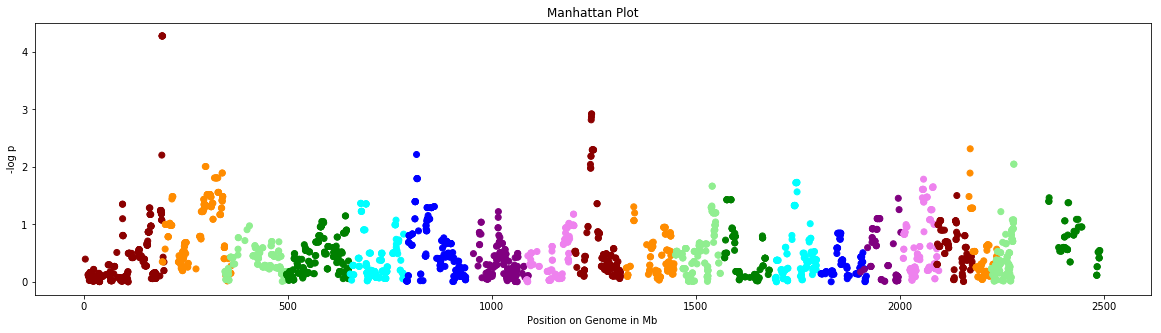

In [47]:
manhattenplot(pd_merged, 'HFD_IL6_[pg/mL]')

In the upper manhatten plot we see the p values for different SNP for the trait 'IL6_[pg/mL]' for the HFD mice . There seems to be one significant SNP in chromosome 1, but nothing else.

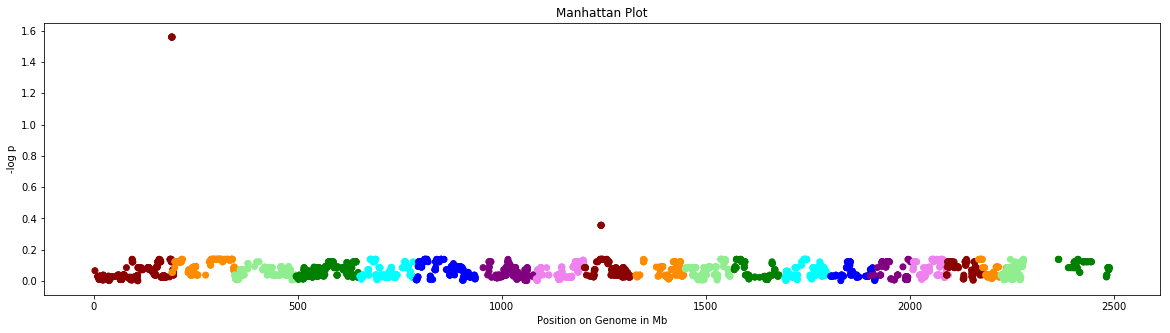

In [48]:
manhattenplot(pd_merged, 'HFD_IL6_[pg/mL] Corrected_p fdr_bh')

After correction the p values with benjamin-hochberg correction the results get even clearer: 
One significant SNP, the rest looks rather boring.

## Task: Interpret results

In [ ]:
#Only one interesting SNP for IL6_[pg/mL] in the HFD mice

## Task: For most interesting examples, try to identify possible candidate genes

## Task: Compare your results to literature

## What confounding factors may have been ignored in the current approach? How could they be incorporated?